In [161]:
import numpy as np
import matplotlib.pyplot as plt
from bandits_utils import *
import pandas as pd

## Work with dataframe

In [321]:
ratings = pd.read_csv('ml-1m/ratings.dat', sep='::', 
                        names = ['UserID', 'MovieID', 'Rating', 'Timestamp'],
                        encoding = 'latin1',
                        engine = 'python')
movies  = pd.read_csv('ml-1m/movies.dat',  sep='::',
                        names = ['MovieID', 'Title', 'Genres'], 
                        encoding = 'latin1',
                        engine ='python')
users   = pd.read_csv('ml-1m/users.dat',  sep='::', 
                        names = ['UserID', 'Gender', 'Age', 'Occupation', 'Zip'], 
                        encoding = 'latin1',
                        engine = 'python')

In [322]:
N = 1000
ratings_count = ratings.groupby(by='MovieID', as_index=True).size()
# top_ratings = ratings_count.sort_values(ascending=False)[:N]
top_ratings = ratings_count[ratings_count>=N]
top_ratings.head(10)

MovieID
1      2077
11     1033
21     1356
32     1511
34     1751
39     1362
47     1137
50     1783
110    2443
111    1240
dtype: int64

In [323]:
movies_topN = movies[movies.MovieID.isin(top_ratings.index)]
# print('Shape: {}'.format(movies_topN.shape))
# movies_topN
ratings_topN = ratings[ratings.MovieID.isin(top_ratings.index)]
print('Shape: {}'.format(ratings_topN.shape))
ratings_topN.head(10)

Shape: (305373, 4)


,UserID,MovieID,Rating,Timestamp
0,1,1193,5,978300760
3,1,3408,4,978300275
4,1,2355,5,978824291
5,1,1197,3,978302268
7,1,2804,5,978300719
9,1,919,4,978301368
10,1,595,5,978824268
13,1,2918,4,978302124
15,1,2791,4,978302188
19,1,2797,4,978302039


In [324]:
n_users = ratings_topN.UserID.unique().shape[0]
n_movies = ratings_topN.MovieID.unique().shape[0]
print('Number of users = {} | Number of movies = {}'.format(n_users, n_movies))

Number of users = 6039 | Number of movies = 207


In [325]:
R_df = ratings_topN.pivot(index = 'UserID', columns ='MovieID', values = 'Rating').fillna(0)
R = np.array(R_df)

In [326]:
R.shape

(6039, 207)

### Work with generated matrix

In [83]:
def generate_matrix(n_users, n_movies, prob) :
    # We fill in the matrix with a non-null value with probability prob to obtain a scarce matrix
    Ratings = []
    for i in range(n_users*n_movies):
        if np.random.random()>prob :
            Ratings.append(0)
        else : 
            Ratings.append(np.random.randint(1,6))
    Ratings = np.array(Ratings).reshape((n_users,n_movies))
    return Ratings

In [68]:
R = generate_matrix(30,60,0.6)
R

array([[5, 2, 4, ..., 0, 1, 3],
       [1, 0, 0, ..., 0, 1, 0],
       [5, 1, 2, ..., 1, 4, 0],
       ...,
       [1, 0, 5, ..., 1, 5, 0],
       [5, 0, 2, ..., 2, 3, 5],
       [3, 4, 2, ..., 4, 0, 0]])

$$R \sim U \cdot M$$

In [327]:
from scipy.sparse.linalg import svds
from sklearn.decomposition import NMF

def fill_matrix_MF(ratings, d, max_iter = 1000):
    """
    Returns a predicted matrix using matrix factorization to deal with zeros(non rated movies)
    """

    model = NMF(n_components=d, init='random', random_state=0, max_iter = max_iter)

    U = model.fit_transform(R)
    M = model.components_

    return U@M

In [328]:
R = fill_matrix_MF(R,10)

In [332]:
len(range(2, 200, 10))

20

## Finding out clusters in our matrix

ValueError: x and y must have same first dimension, but have shapes (18,) and (20,)

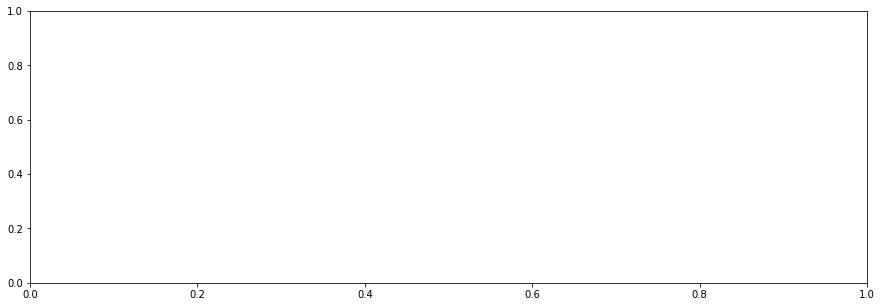

In [333]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

distorsions = []
for k in range(2, 200, 10):
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(R)
    distorsions.append(kmeans.inertia_)

fig = plt.figure(figsize=(15, 5))
plt.plot(range(2, 200, 10), distorsions)
plt.grid(True)
plt.title('Elbow curve')

Text(0.5, 1.0, 'Elbow curve')

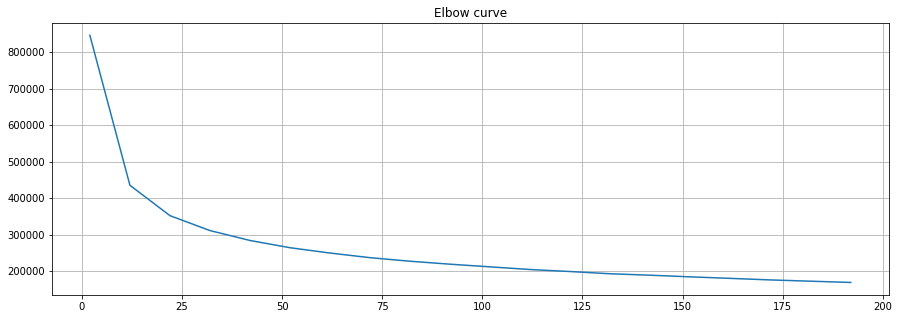

In [334]:
fig = plt.figure(figsize=(15, 5))
plt.plot(range(2, 200, 10), distorsions)
plt.grid(True)
plt.title('Elbow curve')

Text(0.5, 1.0, 'Elbow curve')

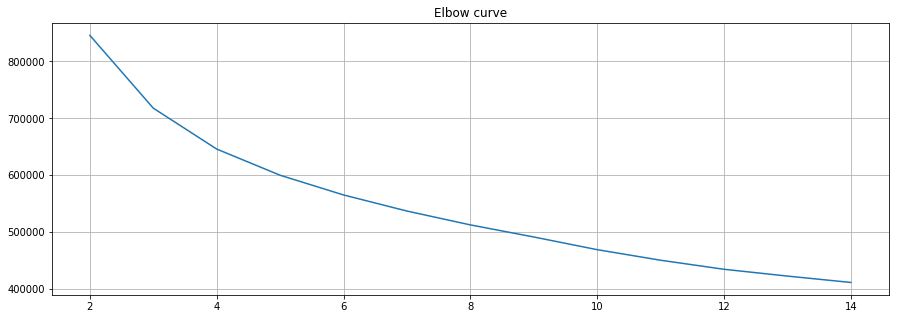

In [347]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

distorsions = []
for k in range(2, 15):
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(R)
    distorsions.append(kmeans.inertia_)

fig = plt.figure(figsize=(15, 5))
plt.plot(range(2, 15), distorsions)
plt.grid(True)
plt.title('Elbow curve')

In [372]:
#Choose number of clusters
nb_clusters = 3
labels = KMeans(nb_clusters, max_iter=1000).fit(R).labels_
print(labels)

[2 0 2 ... 2 2 0]


## Clusters_rating_mean is a matrix of size (M movies x C clusters), in each column there is the mean rating of the cluster

In [373]:
clusters_rating_mean = R.T@np.eye(nb_clusters)[labels]
for i in range(nb_clusters):
    clusters_rating_mean[:,i] = clusters_rating_mean[:,i]/np.count_nonzero(labels == i)

In [374]:
clusters_rating_mean.shape

(207, 3)

In [375]:
best_movies_by_cluster = np.argsort(-1*clusters_rating_mean, axis=0)

In [376]:
best_movies_by_cluster[:,1]

array([ 12,  63,  65, 154,  69,  87,  64,  29,  35, 172,  41,  86,  32,
        13,  80, 111,  17, 115,  24, 135, 166,  23,   7,  58, 167,  71,
         0,   8,  15,  52,  66, 149,  90,  61, 174, 131, 175,  26,  25,
        93, 114,  85,  74, 169, 101, 180, 104,  70, 170,  46, 130, 157,
        21,  54,  73, 122, 179,  49, 140,   3,  55,  31,   4, 127, 198,
        40,  44, 150, 125,  75, 171,  30, 195,  62,  88,  92,  60,  98,
        22, 193,  39,  53, 141,   6, 103,  89,   2,  37,  68, 129, 192,
       112,   5,  76, 143,  36, 128, 197, 108, 147, 200, 116, 182, 194,
       185, 106, 110, 142, 107,  28,  56,  72, 190,  18, 176,  67,   9,
        10,  82, 155, 139,  11,  95,  84, 123,  91,  81,  79, 187, 158,
       138,  77, 145,  94,  43, 188,  57,  83, 178, 119, 144,  96, 121,
        19, 196, 206,  48, 189,  59, 124, 105, 183,  16, 133,  27, 173,
       148, 146,  42, 118, 153, 132,  34, 163,  20,  99,   1, 151, 137,
       117, 113,  33,  14,  51,  50,  47, 201, 164, 134, 161, 20

In [377]:
def get_reward(movie, user) :
    return user[movie]

In [378]:
def UCB(cluster_index, delta, new_user, mu, T):
    if T[cluster_index] == 0:
        return 100000
    else:
        return mu[cluster_index] + np.sqrt(2 * np.log(1/delta)/T[cluster_index])

In [379]:
def UCB_tot(n, new_user, delta, best_movies_by_cluster, k):
    X = np.zeros(n) ##Réalisations (X_t)_t
    T = np.zeros(k, dtype = int) ##T[i] = nb de fois où i a été tiré
    arms_mat = np.zeros((n,k))
    mu = np.zeros(k) ##mu[i] = moyenne empirique de i

    A = np.zeros(n, dtype = int)
    
    for t in range(n):
        all_A_t = np.zeros(k)
        for i in range(k):
            all_A_t[i] = UCB(i, delta, new_user, mu, T) ##On calcul UCB_i pour tous les bras
        A[t] = np.argmax(all_A_t) ##On prend le bras qui a le UCB_i le plus haut
        movie = best_movies_by_cluster[:,A[t]][T[A[t]]]
        X[t] = get_reward(movie,new_user) ##On génère X_t la réalisation à partir du bras choisi
        T[A[t]] += 1 ##Le bras i a été tiré une fois de plus
        arms_mat[t, A[t]] = X[t] ##On stock la valeur de la réalisation dans une matrice
        mu[A[t]] = 1/T[A[t]] * sum(arms_mat[:, A[t]]) ##On update la moyenne empirique
#         Rn[t] = (t+1)*mu_star - T@mu ##On calcul le regret à l'instant t
    return X, A, T, mu

In [382]:
# We take the new user to be a mean between two users of cluster 0 for instance
new_user = np.mean(R[labels==1][:2],axis=0)

In [383]:
n = 30
delta = 1/(n**2)

X_t, arms, T, mu= UCB_tot(n, new_user, delta, best_movies_by_cluster, nb_clusters)

print(arms)
print(mu)
print(X_t)

[0 1 2 0 1 0 1 1 0 1 1 2 1 1 0 1 0 0 1 0 0 1 1 1 0 1 0 2 1 1]
[3.8040058 3.9368749 2.6527674]
[5.79086077 5.79086077 2.71298841 5.46072381 5.46072381 2.71298841
 4.74125744 3.56202453 2.52236609 4.78820619 4.71166524 2.1477293
 4.26591048 3.45559626 3.56202453 2.94155655 4.78820619 4.74125744
 2.71298841 3.45559626 2.80237065 4.1583245  3.68858125 2.80237065
 3.09758449 2.42437582 2.91008512 3.09758449 4.25300975 3.23254672]


* We notice that cluster 0 is the one that has the best rating which is good since the new user is a combination of users of cluster 0 *

In [148]:
# We take the new user to be a mean between two users of cluster 0 for instance
new_user = (4*np.mean(R[labels==3][:4],axis=0) + 2*np.mean(R[labels==0][:2],axis=0))/6

In [149]:
n = 200
delta = 1/(n**2)

X_t, arms, T, mu= UCB_tot(n, new_user, delta, best_movies_by_cluster, nb_clusters)

print(arms)
print(T)
print(mu)

[0 1 2 3 4 5 6 3 4 6 0 1 5 4 6 3 2 0 4 3 1 2 5 6 3 2 0 3 0 4 6 2 1 3 6 5 0
 0 3 2 3 2 2 0 3 1 4 6 0 3 2 1 5 0 2 3 0 4 3 4 1 1 2 3 6 0 3 2 4 1 0 0 5 3
 6 0 3 2 0 2 3 4 0 3 1 2 0 0 3 1 4 6 0 3 0 3 2 1 6 3 0 4 0 2 3 4 5 3 0 2 1
 0 3 6 2 2 0 3 5 0 1 5 3 4 0 2 1 6 3 5 5 5 5 5 0 3 0 0 1 1 2 3 4 2 3 5 0 3
 4 0 3 1 6 2 0 3 0 3 2 1 0 6 3 2 2 4 3 0 0 5 5 5 3 1 0 6 3 4 4 2 5 0 3 3 5
 0 3 2 2 2 3 1 0 0 4 3 6 0 2 3]
[44 21 32 46 20 20 17]
[2.63347338 2.29922999 2.48566008 2.63653168 2.29671906 2.28314252
 2.14347415]


* Here, we notice that cluster 3 is the one with the highest rating and it's reasonable since the new user is 'more of a cluster 3 person than of a cluster 0' *